<a href="https://colab.research.google.com/github/a6iyyu/MachineLearning_3F_23/blob/main/JS6/P5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 5**

Untuk membandingkan ANN, biasanya menggunakan metrics Recall Query (berapa banyak nearest neighbors yang ditemukan dengan benar) dan diplot dalam bentuk grafik untuk dapat memudahkan melihat perbedaannya. Salah satu repo yang sering digunakan adalah ANN Benchmark https://github.com/erikbern/ann-benchmarks

Grafik perbandingan Approximate Nearest Neighbor (ANN) digambarkan dengan sumbu X sebagai recall dan sumbu Y sebagai queries per second (QPS). Recall menunjukkan seberapa banyak tetangga yang benar-benar sesuai dengan hasil pencarian exact nearest neighbor. Nilai recall mendekati 1 berarti hasil pencarian hampir sama persis dengan pencarian exact, sedangkan recall rendah berarti banyak tetangga yang ditemukan salah. Di sisi lain, QPS menunjukkan kecepatan algoritma dalam menjawab query, semakin tinggi nilainya berarti semakin cepat.

Interpretasi grafiknya adalah bahwa posisi kanan atas menunjukkan kondisi ideal, yaitu algoritma yang mampu memberikan hasil akurat (recall tinggi) sekaligus cepat (QPS tinggi). Posisi kanan bawah berarti akurat tapi lambat, sementara kiri atas berarti cepat tetapi kurang akurat. Dengan demikian, setiap algoritma ANN sebenarnya melakukan kompromi antara akurasi dan kecepatan. Semakin kita menginginkan hasil yang lebih akurat, biasanya kecepatan pencarian akan sedikit menurun, sehingga titik grafik cenderung bergeser ke kanan bawah.

![Recall-Queries per second](https://polinema.gitbook.io/jti-modul-praktikum-pembelajaran-mesin-2025-2026/~gitbook/image?url=https%3A%2F%2F3041032130-files.gitbook.io%2F%7E%2Ffiles%2Fv0%2Fb%2Fgitbook-x-prod.appspot.com%2Fo%2Fspaces%252F5CvtE8Xh9b75jKUaRr5Y%252Fuploads%252FOWAusfNlREGvpvw6ZhGW%252Fimage.png%3Falt%3Dmedia%26token%3Df8fac11d-8807-4956-ace8-3d5845a23afd&width=400&dpr=3&quality=100&sign=44cb6ca&sv=2)

Penggunaan Repository ann benchmark memerlukan docker agar dapat dijalankan dengan baik. sayangnya Google Colab belum dilengkapi dengan docker, sehingga kita akan mencoba memvisualisasikan dengan grafik sederhana saja yang akan memberikan hasil yang mirip dengan ann benchmark.

In [4]:
!pip install annoy faiss-cpu hnswlib

In [5]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

In [6]:
# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

In [7]:
# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

In [8]:
# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

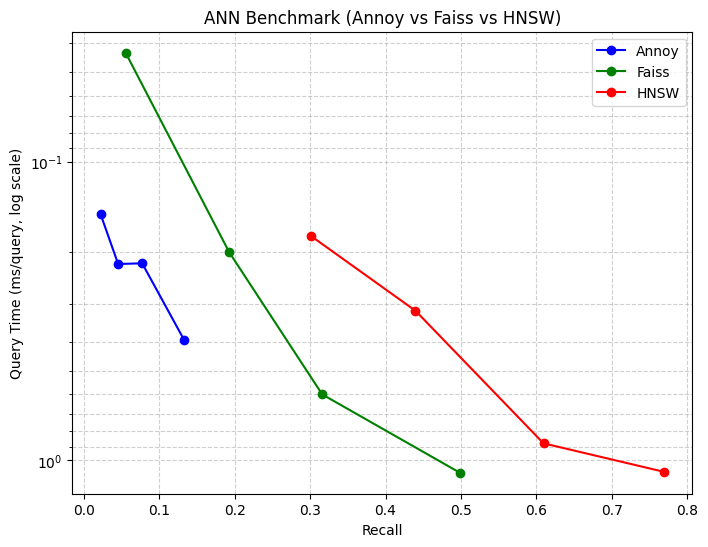

In [9]:
# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()